In [88]:
import folium
import pandas as pd
import numpy as np
import os
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import json
from folium import plugins
import branca.colormap as cm
from tqdm import *

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [89]:
def read_csv(filename):
    df = pd.read_csv(filename)
    NewLap_idx = df[df.Time == 'New Lap'].index.values
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df.dropna(how='any',axis=0, subset=['Time'], inplace=True)
    for lab in ['LongitudeDegrees', 'LatitudeDegrees', 'AltitudeMeters', 'heartratebpm/value']:
        df[lab] = df[lab].interpolate()
    df['dist'] = \
        haversine_np(df.LongitudeDegrees.shift(), df.LatitudeDegrees.shift(),
                     df.loc[1:, 'LongitudeDegrees'], df.loc[1:, 'LatitudeDegrees'])
    df['cum_dis'] = df.dist.cumsum()
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.total_seconds()
    df['Speed'] = df.apply(lambda x: x['dist']/float(x['DeltaTime'])*3600.0 if x['DeltaTime'] > 0.5 else np.NaN, axis=1)
    df['Speed'] = df.apply(lambda x: x['Speed'] if x['Speed'] < 20 else np.NaN, axis=1)
    df['DeltaAltitude'] = df.AltitudeMeters - df.AltitudeMeters.shift()
    return df, NewLap_idx

In [90]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [91]:
path = 'data/csv/'
allFiles = os.listdir(path)
frame = pd.DataFrame(columns=('Date', 'Filename', 'Kilometers', 'Speed', 'Time', 'Climb', 'Lat', 'Long', 'Adress'))
dict_df = dict()
dict_newlap = dict()
for i, file in tqdm(enumerate(allFiles)):
    df, newlap = read_csv(path + file)
    dict_df[df['Time'][0].strftime("%Y-%m-%d")] = df
    dict_newlap[df['Time'][0].strftime("%Y-%m-%d")] = newlap
    geolocator = Nominatim()
    location = geolocator.reverse(str(df.LatitudeDegrees.mean()) + "," + str(df.LongitudeDegrees.mean()))[0]
    frame.loc[i] = [df['Time'][0], file, df.cum_dis.max(), df.Speed.mean(), df.DeltaTime.sum()/60,
                    df['DeltaAltitude'][df['DeltaAltitude'] > 0].sum(),
                    df.LatitudeDegrees.mean(), df.LongitudeDegrees.mean(), location]

44it [00:39,  1.27it/s]


### Session manual add

In [118]:
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Speed'] = 10.9
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Kilometers'] = 8.09
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Time'] = 44.5
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Climb'] = 130

In [119]:
frame.sort_values('Date', ascending=False).head()

,Date,Filename,Kilometers,Speed,Time,Climb,Lat,Long,Adress
31,2017-09-02 08:52:00.450,2017-09-02T08_52_00Z_PT1H58M34S_Running.csv,21.516255,8.859990,121.576833,1717.000,48.777818,2.290877,"EHPAD Résidence Renaudin, Passage Marguerite R..."
22,2017-09-01 05:07:50.590,2017-09-01T05_07_50Z_PT50M7S_Running.csv,8.090000,10.900000,44.500000,130.000,48.842785,2.329997,"Starbucks Coffee, Rue Jules Chaplain, ND-des-C..."
12,2017-08-30 17:20:06.174,Cristian_Perez_2017-08-30_19-20-05.csv,8.146645,11.694941,41.716667,121.772,48.846472,2.335846,"Jardin du Luxembourg, Cour de Jonction, Odéon,..."
35,2017-08-29 17:15:33.209,Cristian_Perez_2017-08-29_19-15-32.csv,8.462380,11.721614,42.616667,164.441,48.846504,2.335784,"Jardin du Luxembourg, Cour de Jonction, Odéon,..."
26,2017-08-26 08:07:54.000,RunnerUp_0051.csv,23.109283,10.833283,122.233333,2713.000,48.778201,2.291200,"EHPAD Résidence Renaudin, Passage Marguerite R..."


In [120]:
recent_frame = frame[frame['Date'] > pd.datetime(2017, 6, 1)]

## Weighted average

In [121]:
np.average(recent_frame.Speed,weights=recent_frame.Kilometers)

11.202151989766888

In [122]:
np.mean(recent_frame.Speed)

11.431096332007908

# Kilometers by date

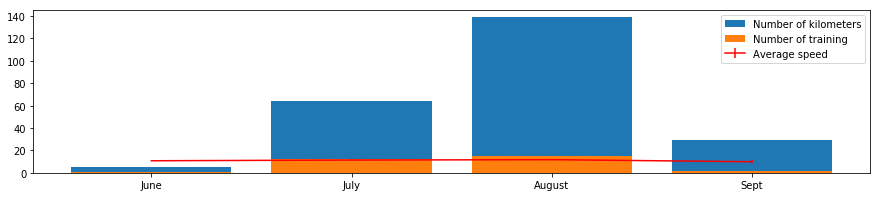

In [123]:
months = ['June', 'July', 'August', 'Sept']
plt.figure(figsize=(15,3))
plt.bar(recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).values, 
        tick_label=months, label='Number of kilometers')
plt.bar(recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'count'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'count'}).values, 
        tick_label=months, label='Number of training')
plt.errorbar(x=recent_frame.groupby(recent_frame.Date.dt.month).agg({'Speed': 'mean'}).index, 
            y=recent_frame.groupby(recent_frame.Date.dt.month).agg({'Speed': 'mean'}).values,
         label='Average speed', yerr=recent_frame.groupby(recent_frame.Date.dt.month).agg({'Speed': 'std'}).values, c='red' )
plt.legend()
plt.show()

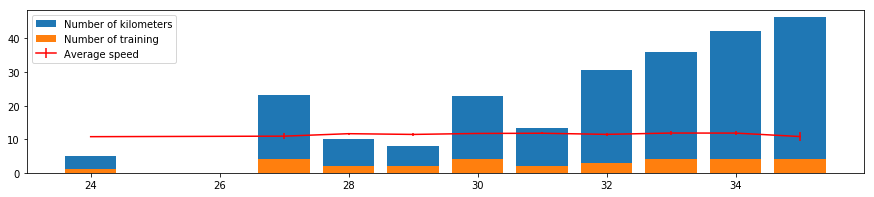

In [124]:
plt.figure(figsize=(15,3))
plt.bar(recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'sum'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'sum'}).values, 
        label='Number of kilometers')
plt.bar(recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).values, 
        label='Number of training')
plt.errorbar(x=recent_frame.groupby(recent_frame.Date.dt.week).agg({'Speed': 'mean'}).index, 
             y=recent_frame.groupby(recent_frame.Date.dt.week).agg({'Speed': 'mean'}).values,
             label='Average speed', yerr=recent_frame.groupby(recent_frame.Date.dt.week).agg({'Speed': 'std'}).values, 
             c='red' )
plt.legend()
plt.show()

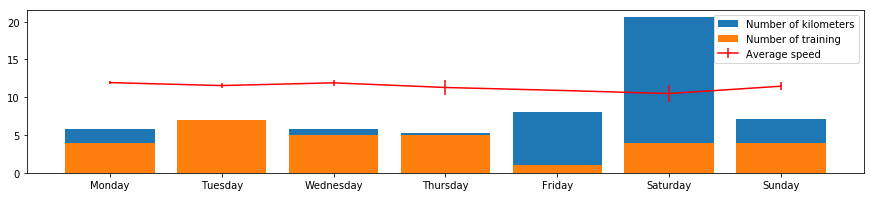

In [125]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(15,3))
plt.bar(recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'mean'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'mean'}).values, 
        tick_label=weekdays, label='Number of kilometers')
plt.bar(recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'count'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'count'}).values, 
        tick_label=weekdays, label='Number of training')
plt.errorbar(x=recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Speed': 'mean'}).index, 
            y=recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Speed': 'mean'}).values,
         label='Average speed', yerr=recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Speed': 'std'}).values, c='red' )
plt.legend()
plt.show()

## Climb by training

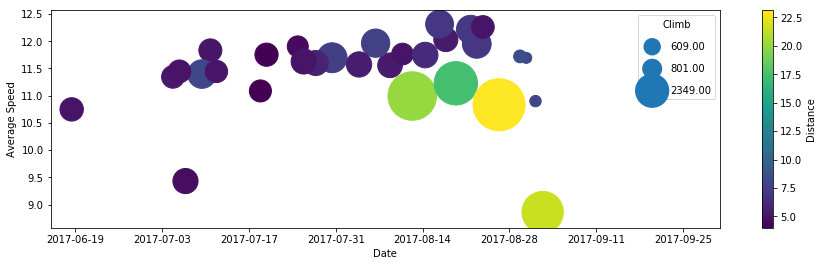

In [126]:
plt.figure(figsize=(15,4))
ax = plt.axes()
ax.set_xlim([pd.datetime(2017,6,15),pd.datetime(2017,10,1)])

legend_sizes = np.sort(recent_frame.Climb)[::len(recent_frame.Climb)//4][-3:]
# get the indices for each of the legend sizes
indices = [np.where(recent_frame.Climb==v)[0][0] for v in legend_sizes]
# plot each point again, and its value as a label
for i in indices:
    plt.scatter(x=recent_frame.Date.iloc[i], y=recent_frame.Speed.iloc[i], c=recent_frame.Kilometers.iloc[i], s=recent_frame.Climb.iloc[i]/2,
                  vmin=0,vmax=1,edgecolors='none',
                  label='{:.2f}'.format(recent_frame.Climb.iloc[i]))
# add the legend
plt.scatter(x=recent_frame.Date.values, y=recent_frame.Speed, c=recent_frame.Kilometers, s=recent_frame.Climb, label=None)
plt.colorbar(label='Distance')
plt.xlabel('Date')
plt.ylabel('Average Speed')
plt.legend(scatterpoints=1, title='Climb', labelspacing=1.2)
plt.show()

In [127]:
list_speed_bubble = []
for k,val in recent_frame.iterrows():
    list_speed_bubble.append({'x': val['Date'].strftime("%Y-%m-%d"), 'y': np.round(val['Speed'],2), 'r': np.round(val['Kilometers'],2)})

## Export json

In [128]:
df_steps = pd.concat([recent_frame.Date.dt.strftime("%s"), recent_frame.Kilometers.round(1)], axis=1)

dic_steps = dict()
for k,x in df_steps.iterrows():
    dic_steps[x['Date']] = x['Kilometers']


In [129]:
with open('output/marathon.json', 'w') as outfile:
    json.dump({'weekday': {'Kilometers': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'mean'}).round(1).values.tolist()],
                           'Speed': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Speed': 'mean'}).round(1).values.tolist()],
                           'Trains': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'count'}).round(1).values.tolist()],
                           'index' : weekdays
                          },
               'week': {'index' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).index.tolist()],
                       'Kilometers': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'sum'}).round(1).values],
                       'Speed': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Speed': 'mean'}).round(1).values],
                       'Trains': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).round(1).values]
                       },
               'month': {'Kilometers' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).round(1).values],
                         'Speed' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Speed': 'mean'}).round(1).values],
                         'Trains' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'count'}).round(1).values],
                         'index' : months
               },
               'heatmap_km': dic_steps,
               'bubble_speed': list_speed_bubble
              }, outfile, indent=1)

# Heatmap folium

In [130]:
mean_lat = np.mean([i[0] for i in [[float(v.Lat), float(v.Long)] for k,v in recent_frame.iterrows()]])
mean_long = np.mean([i[1] for i in [[float(v.Lat), float(v.Long)] for k,v in recent_frame.iterrows()]])
m = folium.Map(location=[mean_lat, mean_long ], zoom_start=11, tiles='OpenStreetMap')
m.add_child(plugins.HeatMap(recent_frame[['Lat','Long']].values, radius = 20), name='Training location')
colormap = cm.LinearColormap(['blue', 'green',  'yellow', 'orange', 'red'],  index=[0, 0.25, 0.5, 0.75, 1.0]).scale(0,20)
colormap.caption = 'Number of trainings'
m.add_child(colormap)
m